In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#df = pd.read_csv('multi_data.csv')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/multi_data.csv')

In [11]:
df

,Predicted_Sales_Lost,Actual_Sales_quantity,Date,Item_Code
0,0,120,1980-01-01,ABCD
1,0,78,1980-02-01,ABCD
2,2,273,1980-03-01,ABCD
3,0,28,1980-04-01,ABCD
4,0,78,1980-05-01,ABCD
...,...,...,...,...
931,0,22,2018-08-01,ABCDE
932,0,136,2018-09-01,ABCDE
933,0,0,2018-10-01,ABCDE
934,0,75,2018-11-01,ABCDE


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936 entries, 0 to 935
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Predicted_Sales_Lost   936 non-null    int64 
 1   Actual_Sales_quantity  936 non-null    int64 
 2   Date                   936 non-null    object
 3   Item_Code              936 non-null    object
dtypes: int64(2), object(2)
memory usage: 29.4+ KB


In [6]:
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d").dt.floor('D')
display(df['Date'].min())
display(df['Date'].max())

Timestamp('1980-01-01 00:00:00')

Timestamp('2018-12-01 00:00:00')

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(7)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [9]:
Scale=StandardScaler()
def data_prep(df, cols, lookback, future, Scale):
    date_train=pd.to_datetime(df['Date'], format="%Y-%m-%d").dt.floor('D')
    df_for_training = df[cols].astype(float)
    
    #df_for_training_scaled=Scale.fit_transform(df_train)
    scaler = Scale.fit(df_for_training)
    df_for_training_scaled = scaler.transform(df_for_training)

    trainX = []
    trainY = []
    for i in range(lookback, len(df_for_training_scaled) - future +1):
        trainX.append(df_for_training_scaled[i - lookback:i, 0:df_for_training.shape[1]])
        trainY.append(df_for_training_scaled[i + future - 1:i + future, 0])

    trainX, trainY = np.array(trainX), np.array(trainY)
        
    return trainX, trainY, df_for_training, date_train

#Lstm_x, Lstm_y, df_train, date_train = data_prep(df, ['Actual_Sales_quantity', 'Predicted_Sales_Lost'], 12, 1, Scale)

In [18]:
def Lstm_model(trainX,trainY):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    #model.add(Dropout(0.2))
    #model.add(BatchNormalization())
    model.add(LSTM(16, activation='relu', return_sequences=True))
    #model.add(Dropout(0.2))
    #model.add(BatchNormalization())
    model.add(LSTM(32, activation='relu', return_sequences=False))
    #model.add(Dropout(0.2))
    #model.add(BatchNormalization())
    model.add(Dense(trainY.shape[1]))

    #opt = keras.optimizers.Adam(learning_rate=0.01)

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()
    
    # fit the model
    #es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    #model.fit(trainX, trainY, epochs=100, batch_size=24, validation_split=0.1, verbose=1, callbacks=[es])
    model.fit(trainX, trainY, epochs=100, batch_size=24, validation_split=0.1, verbose=1)
    
    return model

In [10]:
def predict_open(model, date_train, trainX, df_train, future, Scale):
    forecasting_dates=pd.date_range(list(date_train)[-1], periods=future +1, freq='MS').tolist()
    #from pandas.tseries.offsets import DateOffset
    #forecasting_dates = [df.Date[-1:] + DateOffset(months=x) for x in range(0, future + 1)]
    forecasting_dates.pop(0)
    
    predicted = model.predict(trainX[-future:])
    prediction_copies = np.repeat(predicted, df_train.shape[1], axis=-1)
    predicted_descaled = Scale.inverse_transform(prediction_copies)[:,0]
    
    return predicted_descaled,forecasting_dates

def output_prep(forecasting_dates, predicted_descaled, pred_col_name):
    # Convert timestamp to date
    forecast_dates = []
    for time_i in forecasting_dates:
        forecast_dates.append(time_i.date())
    
    df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), pred_col_name:predicted_descaled})
    df_forecast['Date']=pd.to_datetime(df_forecast['Date']).dt.floor('D')
    df_forecast = df_forecast.round(0)
    
    return df_forecast


In [14]:
def results(df, lookback, future, Scale, cols, pred_col_name, plot_title, n_pred_future):
    Lstm_x, Lstm_y, df_train, date_train = data_prep(df, cols, lookback, future, Scale)
    model=Lstm_model(Lstm_x,Lstm_y)
    loss=pd.DataFrame(model.history.history)
    loss.plot()
    predicted_descaled,forecasting_dates = predict_open(model, date_train, Lstm_x, df_train, n_pred_future, Scale)
    results = output_prep(forecasting_dates, predicted_descaled, pred_col_name)   
    print(results.head())
    plt.show()
    fig = px.area(results, x="Date", y=pred_col_name, title=plot_title)
    fig.update_yaxes(range=[results[pred_col_name].min()-10, results[pred_col_name].max()+10])
    fig.show()
    
    return results

In [ ]:
lookback = 12
future = 1
cols = ['Actual_Sales_quantity', 'Predicted_Sales_Lost']
pred_col_name = 'Actual_Sales_quantity'
plot_title = 'Actual Sales'
n_pred_future = 12

#df_forecast = results(df, lookback, future, Scale, cols, pred_col_name, plot_title, n_pred_future)
df_forecast = pd.DataFrame()
for prod in df.Item_Code.unique():
    print(prod)
    df1 = df[df['Item_Code']==prod]
    res = results(df1, lookback, future, Scale, cols, pred_col_name, plot_title, n_pred_future)
    df_forecast = pd.concat([df_forecast,res])

In [20]:
df_forecast

,Date,Actual_Sales_quantity
0,2019-01-01,36.0
1,2019-02-01,48.0
2,2019-03-01,221.0
3,2019-04-01,412.0
4,2019-05-01,386.0
5,2019-06-01,456.0
6,2019-07-01,216.0
7,2019-08-01,175.0
8,2019-09-01,141.0
9,2019-10-01,128.0


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='Date', ylabel='Actual_Sales_quantity'>

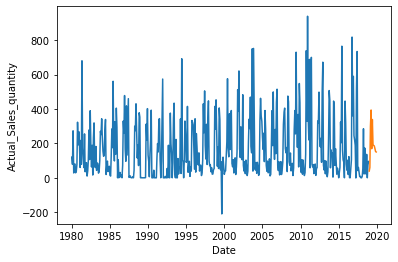

In [ ]:
sns.lineplot(df['Date'], df['Actual_Sales_quantity'])
sns.lineplot(df_forecast['Date'], df_forecast['Actual_Sales_quantity'])

## hyperparameter tunning

In [23]:
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [24]:
lookback = 12
future = 1
cols = ['Actual_Sales_quantity', 'Predicted_Sales_Lost']
pred_col_name = 'Actual_Sales_quantity'
plot_title = 'Actual Sales'
n_pred_future = 12

In [ ]:
Lstm_x, Lstm_y, df_train, date_train = data_prep(df, cols, lookback, future, Scale)

In [ ]:
display(Lstm_x.shape)
display(Lstm_y.shape)

(456, 12, 2)

(456, 1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Lstm_x, Lstm_y, test_size=0.02, random_state=0)

In [ ]:
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(446, 12, 2)

(10, 12, 2)

(446, 1)

(10, 1)

In [ ]:
def build_model(hp):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    #model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(y_train.shape[1], activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    #model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    #model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mean_squared_error', metrics=['mse'])
    
    return model

In [ ]:
LOG_DIR = f"/content/{prod_id}"
tuner= RandomSearch(
        build_model,
        objective='mse',
        max_trials=5,
        executions_per_trial=1,
        directory=LOG_DIR
        )

INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
input_unit (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
lstm_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
layer_2_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
lstm_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


In [ ]:
 stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
 tuner.search(
        x=X_train,
        y=y_train,
        epochs=100,
        batch_size=128,
        validation_data=(X_test,y_test), callbacks=[stop_early]
)

INFO:tensorflow:Oracle triggered exit


In [ ]:
#best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
best_model = tuner.get_best_models()[0]
best_model

In [ ]:
predicted_descaled,forecasting_dates = predict_open(best_model, date_train, Lstm_x, df_train, n_pred_future, Scale)
results = output_prep(forecasting_dates, predicted_descaled, pred_col_name)   
print(results.head())

1/1 [==============================] - 1s 840ms/step
        Date  Actual_Sales_quantity
0 2019-01-01                  167.0
1 2019-02-01                  167.0
2 2019-03-01                  167.0
3 2019-04-01                  167.0
4 2019-05-01                  207.0


In [ ]:
#del tuner

# Hyperparameter Tuning within loop

In [15]:
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.model_selection import train_test_split

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(7)
tf.keras.backend.clear_session()

In [17]:
lookback = 12
future = 1
cols = ['Actual_Sales_quantity', 'Predicted_Sales_Lost']
pred_col_name = 'Actual_Sales_quantity'
plot_title = 'Actual Sales'
n_pred_future = 12

In [18]:
def build_model(hp):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.2,step=0.1)))
    model.add(Dense(y_train.shape[1], activation=hp.Choice('dense_activation',values=['relu', 'tanh'],default='relu')))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mean_squared_error', metrics=['mse'])
    
    return model

In [19]:
df_frcst = pd.DataFrame()
for prod_id in df.Item_Code.unique():
  df1 = df[df['Item_Code']==prod_id]
  Lstm_x, Lstm_y, df_train, date_train = data_prep(df1, cols, lookback, future, Scale)
  X_train, X_test, y_train, y_test = train_test_split(Lstm_x, Lstm_y, test_size=0.02, random_state=0)
  LOG_DIR = f"/content/lstm_hyper/{prod_id}"
  tuner= RandomSearch(
          build_model,
          objective='mse',
          max_trials=5,
          executions_per_trial=1,
          directory=LOG_DIR
          )
  print(f'search_space_summary for {prod_id}: \n',tuner.search_space_summary())
  stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
  tuner.search(
          x=X_train,
          y=y_train,
          epochs=100,
          batch_size=128,
          validation_data=(X_test,y_test), callbacks=[stop_early]
  )
  best_summary = tuner.results_summary(num_trials=1)
  print(f'best_summary for {prod_id} \n:',best_summary)
  best_model = tuner.get_best_models()[0]
  predicted_descaled,forecasting_dates = predict_open(best_model, date_train, Lstm_x, df_train, n_pred_future, Scale)
  results = output_prep(forecasting_dates, predicted_descaled, pred_col_name)
  results['prod_id'] = prod_id
  df_frcst = pd.concat([df_frcst,results])

Trial 5 Complete [00h 00m 27s]
mse: 1.013453722000122

Best mse So Far: 0.9964637160301208
Total elapsed time: 00h 04m 36s
1/1 [==============================] - 2s 2s/step


In [20]:
df_frcst

,Date,Actual_Sales_quantity,prod_id
0,2019-01-01,37.0,ABCD
1,2019-02-01,55.0,ABCD
2,2019-03-01,135.0,ABCD
3,2019-04-01,319.0,ABCD
4,2019-05-01,344.0,ABCD
5,2019-06-01,344.0,ABCD
6,2019-07-01,128.0,ABCD
7,2019-08-01,136.0,ABCD
8,2019-09-01,132.0,ABCD
9,2019-10-01,129.0,ABCD


In [22]:
import os
import shutil
shutil.rmtree('/content/ABCDE')

In [ ]:
# # save the scaler
# import pickle
# pickle.dump(Scale, open('/content/drive/MyDrive/Colab Notebooks/Scale.pkl', 'wb'))
# # load the scaler
# Scale = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Scale.pkl', 'rb'))

# # Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
# model.save("/content/drive/MyDrive/Colab Notebooks/my_h5_model.h5")
# # It can be used to reconstruct the model identically.
# saved_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/my_h5_model.h5")